# 5.0 Modelling

---

# Contents
    
- [1.0 About ARIMAX Model](#1.0-About-ARIMAX-Model)
- [2.0 Load Data](#2.0-Load-Data)
    - [2.1 EUR/USD Data](#2.1-EUR/USD-Data)
    - [2.2 Pattern Data](#2.2-Pattern-Data)
- [3.0 Model](#3.0-Model)
    - [3.1 Train/Test Split](#3.1-Train/Test-Split)
    - [3.2 Fit Model](#3.2-Fit-Model)
    - [3.3 Calculate Results](#3.3-Calculate-Results)
    - [3.4 Run Model](#3.4-Run-Model)
- [4.0 Results](#4.0-Results)
- [5.0 Observations](#5.0-Observations)



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, mean_squared_error
from pmdarima import auto_arima
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")


from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse


In [2]:
pd.set_option('display.max_columns', None)

---

# 1.0 About ARIMAX Model

The Arima model has 3 components:

+ Differencing Step - I - Integrated - Check for stationarity
+ Autoregressive Piece - AR - long term trends
+ Moving Average Piece - MA - Modelling sudden fluctuations

Each part has input into the model P, D, Q.

+ D is the order of differencing we found using the Augmented Dickey-Fuller test.
+ P is the number of autoregressive terms in our model. PACF is used to estimate this.
+ Q is to do with looking at the moving average.
    + If PACF has a sharp cut off and lag-1 for the ACF is negative choose q to be the lag in the ACF before cut off.
    + If PACF does not have a sharp cut off or lag -1 ACF is not negative choose q = 0

Therefore based on the charts before I will use:
    
    + p = 1
    + d = 1
    + q = 0
    
However I will use auto_arima to help decide.

The X in the model stands for Exogenous features which are external features away from the time frame. The time series models look at time as a key factor. This is accurate when time is a key feature in determining price. For example stock control will be lnked to time as the more time the less stock is liekly.

The FOREX market has a lot of external features which are important to drive the prices. Therefore I added gold price, volatility and 2 Moving Averages. The idea is the model can use the extra information to help predict the price.

---

In [3]:
# results = {'algo':'','name':'','date':'', 'time_frame':'','success':0,'RMSE':0, 'MSE':0, 'classification':'' }

# 2.0 Load Data

## 2.1 EUR/USD Data

In [4]:
daily = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/resampled/eur-usd2daily.csv', index_col='date', parse_dates=True)
# daily = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/resampled/eur-usd2daily.csv', 
#                     index_col='date', parse_dates=True)

In [5]:
# daily.loc[(daily.index >= '2000-10-6') & (daily.index <= '2000-10-18')]

In [6]:
daily.columns

Index(['open', 'high', 'low', 'close', 'mid', 'wk_mv_avg', 'mnth_mv_avg',
       'volatility_3_day', 'volatility_10_day', 'pct_chge_3_prds',
       'pct_chge_5_prds', 'pct_chge_10_prds', 'height', 'height-1', 'height-2',
       'height-3', 'direction', 'gold_usd', 'gold_euro', 'marubozu',
       'marubozu+1', 'marubozu-1', 'marubozu-2', 'day-1_open', 'day-2_open',
       'day-3_open', 'day-1_high', 'day-2_high', 'day-3_high', 'day-1_low',
       'day-2_low', 'day-3_low', 'day-1_close', 'day-2_close', 'day-3_close',
       'day+1_open', 'day+1_high', 'day+1_low', 'day+1_close', 'day+2_high',
       'day+2_low', 'day+3_high', 'day+3_low', 'day+4_high', 'day+4_low',
       'day+5_high', 'day+5_low', 'exit_price', 'select', 'target', 'date+5'],
      dtype='object')

In [7]:
daily.head(20)

,open,high,low,close,mid,wk_mv_avg,mnth_mv_avg,volatility_3_day,volatility_10_day,pct_chge_3_prds,pct_chge_5_prds,pct_chge_10_prds,height,height-1,height-2,height-3,direction,gold_usd,gold_euro,marubozu,marubozu+1,marubozu-1,marubozu-2,day-1_open,day-2_open,day-3_open,day-1_high,day-2_high,day-3_high,day-1_low,day-2_low,day-3_low,day-1_close,day-2_close,day-3_close,day+1_open,day+1_high,day+1_low,day+1_close,day+2_high,day+2_low,day+3_high,day+3_low,day+4_high,day+4_low,day+5_high,day+5_low,exit_price,select,target,date+5
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-07-14,0.9353,0.9389,0.9318,0.9383,0.93680,0.94522,0.948145,0.003250,0.003387,-0.016431,-0.014102,-0.017514,0.0030,0.0062,0.0086,0.0041,1.0,97.4,122.0,0,0.0,-1.0,-1.0,0.9416,0.9503,0.9545,0.9425,0.9517,0.9569,0.9330,0.9396,0.9496,0.9354,0.9417,0.9504,0.9382,0.9402,0.9342,0.9360,0.9368,0.9227,0.9270,0.9193,0.9342,0.9204,0.9384,0.9319,0.9413,0,0.9402,2000-07-21
2000-07-17,0.9382,0.9402,0.9342,0.9360,0.93710,0.94217,0.947100,0.004282,0.003440,-0.009408,-0.016013,-0.014875,0.0022,0.0030,0.0062,0.0086,-1.0,98.1,123.3,0,-1.0,0.0,-1.0,0.9353,0.9416,0.9503,0.9389,0.9425,0.9517,0.9318,0.9330,0.9396,0.9383,0.9354,0.9417,0.9361,0.9368,0.9227,0.9256,0.9270,0.9193,0.9342,0.9204,0.9384,0.9319,0.9367,0.9313,0.9338,0,0.9193,2000-07-24
2000-07-18,0.9361,0.9368,0.9227,0.9256,0.93085,0.93785,0.945633,0.003582,0.003797,-0.008151,-0.022678,-0.020519,0.0105,0.0022,0.0030,0.0062,-1.0,98.3,123.8,-1,0.0,0.0,0.0,0.9382,0.9353,0.9416,0.9402,0.9389,0.9425,0.9342,0.9318,0.9330,0.9360,0.9383,0.9354,0.9255,0.9270,0.9193,0.9246,0.9342,0.9204,0.9384,0.9319,0.9367,0.9313,0.9433,0.9329,0.9151,0,0.9193,2000-07-25
2000-07-19,0.9255,0.9270,0.9193,0.9246,0.92505,0.93366,0.944207,0.003915,0.003618,-0.012543,-0.022146,-0.029125,0.0009,0.0105,0.0022,0.0030,-1.0,97.0,123.3,0,1.0,-1.0,0.0,0.9361,0.9382,0.9353,0.9368,0.9402,0.9389,0.9227,0.9342,0.9318,0.9256,0.9360,0.9383,0.9245,0.9342,0.9204,0.9325,0.9384,0.9319,0.9367,0.9313,0.9433,0.9329,0.9450,0.9391,0.9237,0,0.9204,2000-07-26
2000-07-20,0.9245,0.9342,0.9204,0.9325,0.92850,0.93166,0.943221,0.005881,0.004167,-0.009177,-0.010655,-0.024531,0.0080,0.0009,0.0105,0.0022,1.0,97.1,123.3,1,0.0,0.0,-1.0,0.9255,0.9361,0.9382,0.9270,0.9368,0.9402,0.9193,0.9227,0.9342,0.9246,0.9256,0.9360,0.9324,0.9384,0.9319,0.9365,0.9367,0.9313,0.9433,0.9329,0.9450,0.9391,0.9444,0.9314,0.9405,0,0.9450,2000-07-27
2000-07-21,0.9324,0.9384,0.9319,0.9365,0.93445,0.93119,0.942879,0.006660,0.005033,0.003867,-0.002509,-0.016575,0.0041,0.0080,0.0009,0.0105,1.0,97.1,122.2,0,0.0,1.0,0.0,0.9245,0.9255,0.9361,0.9342,0.9270,0.9368,0.9204,0.9193,0.9227,0.9325,0.9246,0.9256,0.9366,0.9367,0.9313,0.9330,0.9433,0.9329,0.9450,0.9391,0.9444,0.9314,0.9338,0.9229,0.9406,0,0.9450,2000-07-28
2000-07-24,0.9366,0.9367,0.9313,0.9330,0.93480,0.93073,0.942807,0.003023,0.004904,0.010540,-0.002454,-0.018428,0.0036,0.0041,0.0080,0.0009,-1.0,97.2,122.3,0,1.0,0.0,1.0,0.9324,0.9245,0.9255,0.9384,0.9342,0.9270,0.9319,0.9204,0.9193,0.9365,0.9325,0.9246,0.9329,0.9433,0.9329,0.9412,0.9450,0.9391,0.9444,0.9314,0.9338,0.9229,0.9295,0.9224,0.9294,0,0.9224,2000-07-31
2000-07-25,0.9329,0.9433,0.9329,0.9412,0.93705,0.93197,0.942790,0.003070,0.005057,0.009208,0.006661,-0.016169,0.0083,0.0036,0.0041,0.0080,1.0,97.2,121.2,1,0.0,0.0,0.0,0.9366,0.9324,0.9245,0.9367,0.9384,0.9342,0.9313,0.9319,0.9204,0.9330,0.9365,0.9325,0.9411,0.9450,0.9391,0.9435,0.9444,0.9314,0.9338,0.9229,0.9295,0.9224,0.9293,0.9135,0.9495,0,0.9450,2000-08-01
2000-07-26,0.9411,0.9450,0.9391,0.9435,0.94230,0.93542,0.942795,0.002636,0.005168,0.008401,0.018648,-0.003911,0.0024,0.0083,0.0036,0.0041,1.0,97.1,121.0,0,-1.0,1.0,0.0,0.9329,0.9366,0.9324,0.9433,0.9367,0.9384,0.9329,0.9313,0.9319,0.9412,0.9330,0.9365,0.9434,0.9444,0.9314,0.9319,0.9338,0.9229,0.9295,0.9224,0.9293,0.9135,0.9192,0.9117,0.9459,0,0.9444,2000-08-02


In [8]:
### Get correct hyper parameters

In [9]:
## Arima
auto_arima(daily['close'].dropna(), seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4612
Model:               SARIMAX(0, 1, 0)   Log Likelihood               15826.945
Date:                Tue, 04 Aug 2020   AIC                         -31651.890
Time:                        15:09:27   BIC                         -31645.453
Sample:                             0   HQIC                        -31649.624
                               - 4612                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       6.11e-05   5.15e-07    118.588      0.000    6.01e-05    6.21e-05
===================================================================================
Ljung-Box (Q):                       61.33   Jarque-Bera (JB):             20105.01
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

---

## 2.2 Pattern Data

In [10]:
daily_pattern = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/targets/daily_pattern2.csv', 
                           parse_dates=True)

In [11]:
daily_pattern.head()

,pattern_end
0,2000-10-11
1,2000-10-20
2,2001-04-05
3,2001-04-09
4,2001-08-20


In [12]:
daily_pattern['pattern_end'] = pd.to_datetime(daily_pattern['pattern_end'])

In [13]:
daily_pattern.loc[0]

pattern_end   2000-10-11
Name: 0, dtype: datetime64[ns]

In [14]:
len(daily_pattern)

62

---

# 3.0 Model

## 3.1 Train/Test Split

In [15]:
def create_train_test_split(date, time_series, model_info):

    # Get index of pattern and add 6 (so 5) extra rows for Test/train set
    test_end_loc = time_series.index.get_loc(date) + 6
    
    # Create train/test set using index loc of pattern 
    train_test = time_series.iloc[:test_end_loc]
    
    # Set target values
    target_value = time_series.loc[time_series.index == date,'exit_price'].item()
    
    # add target price to dataset
    train_test.insert(0, 'target_price', target_value)
    
    # Add Signal so it can be determined whether we expect the price to go up or down.
    model_info['signal'] = time_series.loc[date,'marubozu']
    
    # insert the signal to dataset
    train_test.insert(0, 'signal', model_info['signal'])
    
    # create start and end points for the test/train splits
    model_info['start'] = len(train_test)-5
    model_info['end'] = len(train_test)-1
    
    # create the train and data sets
    model_info['train'] = train_test.iloc[:model_info['start']]
    model_info['test'] = train_test.iloc[model_info['start']:]

    return model_info

## 3.2 Fit Model

In [16]:
def train_arima(model_info, p=0, d=1, q=0):
    
    exog = np.column_stack([model_info['train']['mnth_mv_avg'], 
                            model_info['train']['wk_mv_avg'],
                            model_info['train']['volatility_3_day'],
                            model_info['train']['gold_euro'],
                            model_info['train']['gold_usd']])
    
    if model_info['signal'] == -1:
        model = ARIMA(model_info['train']['low'], exog=exog, order=(p,d,q))
    else:
        model = ARIMA(model_info['train']['high'], exog=exog, order=(p,d,q))

    results = model.fit()
    predictions = results.predict(start=model_info['start'], 
                                  end=model_info['end'], exog=exog,
                                  dynamic=True, 
                                  typ='levels').rename('ARIMA-0-1-0 Predictions')
    
    return results, predictions

## 3.3 Calculate Results

In [17]:
def meet_threshold(row):
    if row['signal'] == -1 and row['low'] <= row['target_price']:
        return -1
    elif row['signal'] == 1 and row['high'] >= row['target_price']:
        return 1    
    else:
        return 0

In [18]:
def ml_decision(row):
    if row['direction'] == -1 and row['preds'] <= row['target_price']:
        return -1
    elif row['direction'] == 1 and row['preds'] >= row['target_price']:
        return 1    
    else:
        return 0

In [19]:
def create_results_outcomes_dataframe(test, predictions):    
    outcomes = pd.DataFrame()
    outcomes['low'] = test['low']
    outcomes['high'] = test['high']
    outcomes['preds'] = predictions.values
    outcomes['target_price'] = test['target_price']
    outcomes['direction'] = test['signal']
    outcomes['correct_call'] = test.apply(meet_threshold, axis=1)
    return outcomes

In [20]:
def print_chart(outcomes):
    if model_info['signal'] == -1:
        outcomes['low'].plot(legend=False, figsize=(12,8))
    else:
        outcomes['high'].plot(legend=False, figsize=(12,8))

    outcomes['preds'].plot(legend=False);
    outcomes['target_price'].plot(legend=False);

In [21]:
def get_results(model_info):
        
    if model_info['signal'] == -1:
        mse = mean_squared_error(model_info['test']['low'], predictions)
        rmse_res = rmse(model_info['test']['low'], predictions)
    else:
        mse = mean_squared_error(model_info['test']['high'], predictions)
        rmse_res = rmse(model_info['test']['high'], predictions)       
    
    return rmse_res, mse

In [22]:
def classify(outcomes):
    
    if max(outcomes['direction']) == 1:
        
        if max(outcomes['correct_call']) == 0 and max(outcomes['ml_correct_call']) == 0:
            return 'tn'
        elif max(outcomes['correct_call']) == 1 and max(outcomes['ml_correct_call']) == 1:
            return 'tp'
        elif max(outcomes['correct_call']) == 0 and max(outcomes['ml_correct_call']) == 1:
            return 'fp'
        elif max(outcomes['correct_call']) == 1 and max(outcomes['ml_correct_call']) == 0:
            return 'fn'
        
    elif max(outcomes['direction']) == -1:
        
        if min(outcomes['correct_call']) == 0 and min(outcomes['ml_correct_call']) == 0:
            return 'tn'
        elif min(outcomes['correct_call']) == -1 and min(outcomes['ml_correct_call']) == -1:
            return 'tp'
        elif min(outcomes['correct_call']) == 0 and min(outcomes['ml_correct_call']) == -1:
            return 'fp'
        elif min(outcomes['correct_call']) == -1 and min(outcomes['ml_correct_call']) == 0:
            return 'fn'
        
    else:
        return 'ERROR'
    

## 3.4 Run Model

In [65]:
arima_results = []

for match in daily_pattern['pattern_end']:
    
    model_info = {"train":None,"test":None,"start":None,"end":None,"signal":None}

    
    results_dict = {'name':'arima-0-1-0','strategy':'marubozu','date':match,
                   'time_frame':'daily','RMSE':None,
                   'MSE':None, 'classification':None}
    

    model_info = create_train_test_split(match, daily, model_info)

    if len(model_info['train']) < 10:
        continue

    results, predictions = train_arima(model_info)
    

    outcomes = create_results_outcomes_dataframe(model_info['test'], predictions)
    outcomes['ml_correct_call'] = outcomes.apply(ml_decision, axis=1)

    results_dict['RMSE'], results_dict['MSE'] = get_results(model_info)
    results_dict['classification'] = classify(outcomes)

    arima_results.append(results_dict)
    

In [66]:
# Check no errors
def check_no_errors(results_list):
    errors = 0
    for result in arima_results:
        res = result['classification']
        if res == 'ERROR':
            errors+=1
    
    if errors == 0:
        print("All patterns recorded correctly")
    elif errors > 0:
        print(f"Warning: there were {errors} errors recorded")

In [67]:
check_no_errors(arima_results)

All patterns recorded correctly


---

# 4.0 Results

In [68]:
def create_cm(arima_results):
    
    res_cm = [[0,0],
              [0,0]]
    
    for result in arima_results:
        res = result['classification']
        
        if res == 'tp':
            res_cm[0][0] += 1
        elif res == 'fp':
            res_cm[0][1] += 1
        elif res == 'fn':
            res_cm[1][0] += 1
        elif res == 'tn':
            res_cm[1][1] += 1
    
    return res_cm

In [69]:
cm = create_cm(arima_results)

In [70]:
cm_df = pd.DataFrame(cm, index=['pred_success', 'pred_non_success'], columns=['actual success', 'actual non_success'])
cm_df

,actual success,actual non_success
pred_success,13,4
pred_non_success,27,18


In [71]:
def print_metrics(cm):
    # Accuracy - how many did the model get right
    # Total number of correct predictions / total number of predictions
    acc= (cm[0][0]+cm[1][1])/(np.sum(cm))
    
    # Precision proportion of positive identifications that were actually correct
    # True positives/ true positives + false positives)
    prec = cm[0][0]/(cm[0][0]+cm[0][1])
    
    # Recall - proportion of actual positives that were correctly defined
    # True positives/ true positives + false negatives
    rec = cm[0][0]/(cm[0][0]+cm[1][0])

    print(f"Accuracy:\t{round(acc,2)}\nPrecision:\t{round(prec,2)}\nRecall:\t\t{round(rec,2)}")


In [72]:
# Display the results
print_metrics(cm)

Accuracy:	0.5
Precision:	0.76
Recall:		0.33


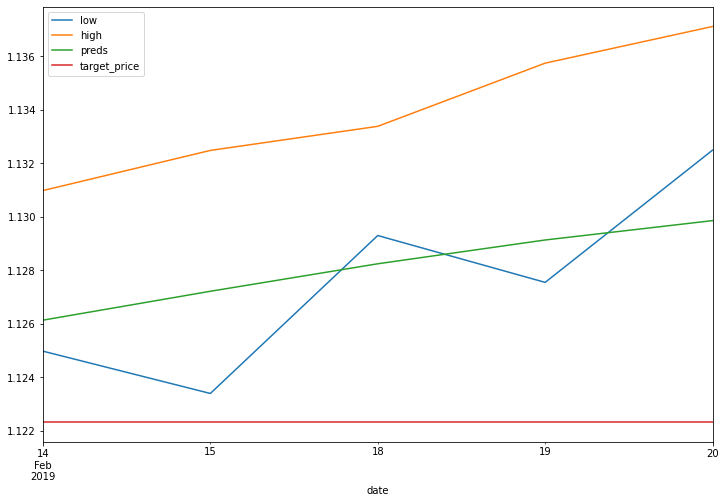

In [73]:
outcomes['low'].plot(legend=True, figsize=(12,8))
outcomes['high'].plot(legend=True)
outcomes['preds'].plot(legend=True);
outcomes['target_price'].plot(legend=True);


In [74]:
arima_results_df = pd.DataFrame(arima_results)
arima_results_df

,name,strategy,date,time_frame,RMSE,MSE,classification
0,arima-0-1-0,marubozu,2000-10-11,daily,0.004065,0.000017,tp
1,arima-0-1-0,marubozu,2000-10-20,daily,0.011222,0.000126,tp
2,arima-0-1-0,marubozu,2001-04-05,daily,0.006349,0.000040,tp
3,arima-0-1-0,marubozu,2001-04-09,daily,0.006417,0.000041,tp
4,arima-0-1-0,marubozu,2001-08-20,daily,0.009487,0.000090,tp
...,...,...,...,...,...,...,...
57,arima-0-1-0,marubozu,2018-09-14,daily,0.003028,0.000009,tn
58,arima-0-1-0,marubozu,2018-10-22,daily,0.012050,0.000145,fn
59,arima-0-1-0,marubozu,2018-12-10,daily,0.008124,0.000066,fn
60,arima-0-1-0,marubozu,2019-01-31,daily,0.009717,0.000094,fn


In [75]:
# Save resutls
arima_results_df.to_csv('/Users/stuartdaw/Documents/Capstone_data/model_results/arima_results.csv', index=False)

---

# 5.0 Observations